In [ ]:
!rm /content/lanenet-lane-detection
!git clone https://github.com/MaybeShewill-CV/lanenet-lane-detection.git

rm: cannot remove '/content/lanenet-lane-detection': No such file or directory
Cloning into 'lanenet-lane-detection'...
remote: Enumerating objects: 851, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 851 (delta 140), reused 134 (delta 134), pack-reused 683
Receiving objects: 100% (851/851), 57.42 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (474/474), done.


In [ ]:
!pip3 install -r lanenet-lane-detection/requirements.txt

     |████████████████████████████████| 40 kB 4.3 MB/s 
     |████████████████████████████████| 411.5 MB 6.7 kB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 
     |████████████████████████████████| 12.8 MB 45.2 MB/s 
     |████████████████████████████████| 34.2 MB 66 kB/s 
     |████████████████████████████████| 17.3 MB 573 kB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
     |████████████████████████████████| 412.3 MB 28 kB/s 
     |████████████████████████████████| 636 kB 46.5 MB/s 
     |████████████████████████████████| 52 kB 891 kB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.8 MB 13.4 MB/s 
     |████████████████████████████████| 503 kB 52.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=435699b679a285abff07a02f1fe686f5d882b576046826b611c1e74c3a0d780e
  Stored in directory: /root/.cache/pip/wheels/21/7f

In [ ]:
import tensorflow as tf
assert(tf.__version__ == '1.15.0')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!mkdir /content/lanenet-lane-detection/lanenet_pretrained_model

#Saksham Path
# !unzip "/content/drive/MyDrive/Colab Notebooks/EE292D/BiseNetV2_LaneNet_Tusimple_Model_Weights" -d '/content/lanenet-lane-detection/lanenet_pretrained_model/'

#Ioanna's Path
# !unzip /content/gdrive/MyDrive/BiseNetV2_LaneNet_Tusimple_Model_Weights.zip -d /content/lanenet-lane-detection/lanenet_pretrained_model/

# Pranil's Path
%cd /content/
!unzip /content/gdrive/MyDrive/Colab\ Notebooks/BiseNetV2_LaneNet_Tusimple_Model_Weights.zip -d lanenet-lane-detection/lanenet_pretrained_model/


/content
Archive:  /content/gdrive/MyDrive/Colab Notebooks/BiseNetV2_LaneNet_Tusimple_Model_Weights.zip
mapname:  conversion of  failed
 extracting: lanenet-lane-detection/lanenet_pretrained_model/checkpoint  
 extracting: lanenet-lane-detection/lanenet_pretrained_model/tusimple_lanenet.ckpt.meta  
 extracting: lanenet-lane-detection/lanenet_pretrained_model/tusimple_lanenet.ckpt.index  
 extracting: lanenet-lane-detection/lanenet_pretrained_model/tusimple_lanenet.ckpt.data-00000-of-00001  


In [ ]:
# Common dependencies

%cd lanenet-lane-detection/
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lanenet_model import lanenet_postprocess
from local_utils.config_utils import parse_config_utils

CFG = parse_config_utils.lanenet_cfg

def minmax_scale(input_arr):
    """
    :param input_arr:
    :return:
    """
    min_val = np.min(input_arr)
    max_val = np.max(input_arr)

    output_arr = (input_arr - min_val) * 255.0 / (max_val - min_val)

    return output_arr

/content/lanenet-lane-detection


# 10/26 Saving TF model as a .pb file

INFO:tensorflow:Restoring parameters from ./lanenet_pretrained_model/tusimple_lanenet.ckpt


I1205 01:40:27.105786 61 saver.py:1284] Restoring parameters from ./lanenet_pretrained_model/tusimple_lanenet.ckpt
2021-12-05 01:40:27.496 | INFO     | __main__:test_lanenet:67 - Weights loaded, cost time: 0.39169s
2021-12-05 01:40:28.680 | INFO     | __main__:test_lanenet:79 - Single imgae inference cost time: 0.72886s


AttributeError: ignored

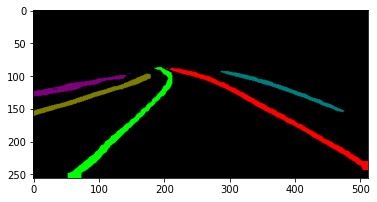

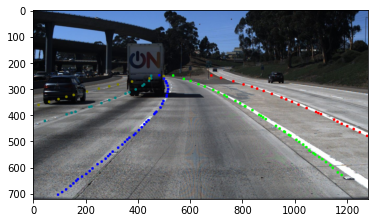

In [ ]:
import os.path as ops
import tensorflow as tf
import time

from lanenet_model import lanenet
from local_utils.log_util import init_logger

LOG = init_logger.get_logger(log_file_name_prefix='lanenet_test')

def getPreprocessedImage(image_path):
    assert ops.exists(image_path), '{:s} does not exist'.format(image_path)

    # LOG.info('Start reading image and preprocessing')
    # t_start = time.time()
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_vis = image
    image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR)
    image = image / 127.5 - 1.0
    # LOG.info('Image load complete, cost time: {:.5f}s'.format(time.time() - t_start))

    return image, image_vis

def test_lanenet(image_path, weights_path, mode="ckptinference", export_path = None):
    """
    :param image_path:
    :param mode:
      "ckptinference": Run inference on ckpt model obtained from GitHub
      "ckpttopb": Save new .pb model to export_path
      "pbinference": Run inference on pb model located in weights_path directory
    :param weights_path:
    :export_path
    :return:
    """
    image, image_vis = getPreprocessedImage(image_path)

    tf.reset_default_graph()

    if(mode != "pbinference"):
        input_tensor = tf.placeholder(dtype=tf.float32, shape=[1, 256, 512, 3], name='input_tensor')
        net = lanenet.LaneNet(phase='test', cfg=CFG)
        binary_seg_ret, instance_seg_ret = net.inference(input_tensor=input_tensor, name='LaneNet')

    postprocessor = lanenet_postprocess.LaneNetPostProcessor(cfg=CFG)
    # Set sess configuration
    sess_config = tf.ConfigProto()
    sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.GPU.GPU_MEMORY_FRACTION
    sess_config.gpu_options.allow_growth = CFG.GPU.TF_ALLOW_GROWTH
    sess_config.gpu_options.allocator_type = 'BFC'

    sess = tf.Session(config=sess_config)

    if(mode != "pbinference"):
        # define moving average version of the learned variables for eval
        with tf.variable_scope(name_or_scope='moving_avg'):
            variable_averages = tf.train.ExponentialMovingAverage(
                CFG.SOLVER.MOVING_AVE_DECAY)
            variables_to_restore = variable_averages.variables_to_restore()

        # define saver
        saver = tf.train.Saver(variables_to_restore)

    with sess.as_default():
        if(mode != "pbinference"):
            t_start_sess = time.time()
            # saver = tf.train.import_meta_graph(weights_path+ '.meta')
            saver.restore(sess=sess, save_path=weights_path)
            LOG.info('Weights loaded, cost time: {:.5f}s'.format(time.time() - t_start_sess))
            saver.save(sess, 'MODEL_TF')

            t_start = time.time()
            loop_times = 1 # 500
            for i in range(loop_times):
                binary_seg_image, instance_seg_image = sess.run(
                    [binary_seg_ret, instance_seg_ret],
                    feed_dict={input_tensor: [image]}
                )
            t_cost = time.time() - t_start
            t_cost /= loop_times
            LOG.info('Single imgae inference cost time: {:.5f}s'.format(t_cost))

        if(mode == "ckpttopb"):
          tf.saved_model.simple_save(session=sess, export_dir=export_path,
                                   inputs={'image': input_tensor},
                                  outputs={
                                      'binary_seg_image': binary_seg_ret,
                                      'instance_seg_image': instance_seg_ret
                                  })
                  # # Untested alternative: Save with SavedModelBuilder
                  # builder = tf.saved_model.Builder('/content/temp/')
                  # sig_def = tf.saved_model.predict_signature_def(
                  #     inputs={'image': input_tensor},
                  #     outputs={'binary_seg_image': binary_seg_ret, 'instance_seg_image': instance_seg_ret})
                  # builder.add_meta_graph_and_variables(
                  #     sess, tags=["serve"], signature_def_map={
                  #         tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY: sig_def
                  # })
                  # builder.save()
        else:
            if(mode=="pbinference"):
                meta_graph = tf.saved_model.load(sess=sess, tags=["serve"], export_dir=weights_path)
                sig_def = meta_graph.signature_def[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

                input_name = sig_def.inputs['image'].name
                output_name1 = sig_def.outputs['binary_seg_image'].name
                # o1 = tf.get_default_graph().get_tensor_by_name(output_name1)
                output_name2 = sig_def.outputs['instance_seg_image'].name
                # o2 = tf.get_default_graph().get_tensor_by_name(output_name2)

                t_start = time.time()
                loop_times = 1 # 500
                for i in range(loop_times):
                    binary_seg_image, instance_seg_image = sess.run(
                        [output_name1, output_name2],
                            feed_dict={input_name: [image]}
                    )
                t_cost = time.time() - t_start
                t_cost /= loop_times
                LOG.info('Single imgae inference cost time: {:.5f}s'.format(t_cost))

            postprocess_result = postprocessor.postprocess(
                binary_seg_result=binary_seg_image[0],
                instance_seg_result=instance_seg_image[0],
                source_image=image_vis
            )
            mask_image = postprocess_result['mask_image']

            for i in range(CFG.MODEL.EMBEDDING_FEATS_DIMS):
                instance_seg_image[0][:, :, i] = minmax_scale(instance_seg_image[0][:, :, i])
            embedding_image = np.array(instance_seg_image[0], np.uint8)

            plt.figure('mask_image')
            plt.imshow(mask_image[:, :, (2, 1, 0)])
            plt.figure('src_image')
            plt.imshow(image_vis[:, :, (2, 1, 0)])
            plt.save('src.png')
            plt.figure('instance_image')
            plt.imshow(embedding_image[:, :, (2, 1, 0)])
            plt.figure('binary_image')
            plt.imshow(binary_seg_image[0] * 255, cmap='gray')
            plt.show()

    sess.close()

    return


# ckpt Inference
image_path = './data/tusimple_test_image/0.jpg'
weights_path = './lanenet_pretrained_model/tusimple_lanenet.ckpt'
test_lanenet(image_path, weights_path, mode="ckptinference")

# # Save pb model
# image_path = './data/tusimple_test_image/0.jpg'
# weights_path = './lanenet_pretrained_model/tusimple_lanenet.ckpt'
# export_path = '/content/pbmodel1026/'
# test_lanenet(image_path, weights_path, mode="ckpttopb", export_path=export_path)

# # pb inference
# image_path = './data/tusimple_test_image/0.jpg'
# weights_path = '/content/pbmodel1026/'
# test_lanenet(image_path, weights_path, mode="pbinference")

In [ ]:
!zip -r /content/pbmodel1026.zip /content/pbmodel1026

  adding: content/pbmodel1026/ (stored 0%)
  adding: content/pbmodel1026/saved_model.pb (deflated 95%)
  adding: content/pbmodel1026/variables/ (stored 0%)
  adding: content/pbmodel1026/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/pbmodel1026/variables/variables.index (deflated 70%)


# 11/01 Convert .pb to .tflite
## Both Unquantized and Quantized Models

In [ ]:
!rm -rf /content/repdata/

NOTE: Please upload repdata.zip before proceeding.

In [ ]:
def PbToTflite(weights_path, export_path, quantize=True, repdatazip_path=''):
    ## repdatazip_path: Path to zip file for representative data. Only used if quantize==True

    import os

    converter = tf.lite.TFLiteConverter.from_saved_model(weights_path)

    if(quantize):
        import zipfile
        repdata_path = '/content/'
        with zipfile.ZipFile(repdatazip_path, 'r') as zip_ref:
            zip_ref.extractall(repdata_path)
            
        repdata = []
        for subdir, dirs, files in os.walk(repdata_path+'repdata/'):
            for file in files:
                filepath = os.path.join(subdir, file)
                image, image_vis = getPreprocessedImage(filepath)
                test = np.expand_dims(image, axis=0)
                test = test.astype('float32')
                repdata.append(test)

        def representative_dataset():
            for i in range(len(repdata)):
                yield([repdata[i]])

        # Set the optimization flag.
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # Enforce integer only quantization
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
        # Provide a representative dataset to ensure we quantize correctly.
        converter.representative_dataset = representative_dataset

    model = converter.convert()

    # Save the model to disk
    os.mkdir(export_path)
    open(export_path+'/saved_model.tflite', "wb").write(model)

# Unquantized TFLite
# weights_path = '/content/pbmodel1026'
# export_path = '/content/tflitemodel1026'
# PbToTflite(weights_path, export_path, quantize=False)

# Quantized TFLite
weights_path = '/content/pbmodel1026'
export_path = '/content/tflitemodelquantized1101'
repdatazip_path = '/content/repdata.zip'
PbToTflite(weights_path, export_path, repdatazip_path=repdatazip_path)

INFO:tensorflow:Restoring parameters from /content/pbmodel1026/variables/variables


I1110 19:21:01.609574 66 saver.py:1284] Restoring parameters from /content/pbmodel1026/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


I1110 19:21:02.189230 66 convert_saved_model.py:80] The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


I1110 19:21:02.196566 66 convert_saved_model.py:99] input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: image


I1110 19:21:02.202546 66 convert_saved_model.py:41] Tensor's key in saved_model's tensor_map: image


INFO:tensorflow: tensor name: input_tensor:0, shape: (1, 256, 512, 3), type: DT_FLOAT


I1110 19:21:02.208419 66 convert_saved_model.py:43]  tensor name: input_tensor:0, shape: (1, 256, 512, 3), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


I1110 19:21:02.217835 66 convert_saved_model.py:101] output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: binary_seg_image


I1110 19:21:02.226127 66 convert_saved_model.py:41] Tensor's key in saved_model's tensor_map: binary_seg_image


INFO:tensorflow: tensor name: LaneNet/bisenetv2_backend/binary_seg/ArgMax:0, shape: (1, 256, 512), type: DT_INT64


I1110 19:21:02.233571 66 convert_saved_model.py:43]  tensor name: LaneNet/bisenetv2_backend/binary_seg/ArgMax:0, shape: (1, 256, 512), type: DT_INT64


INFO:tensorflow:Tensor's key in saved_model's tensor_map: instance_seg_image


I1110 19:21:02.241846 66 convert_saved_model.py:41] Tensor's key in saved_model's tensor_map: instance_seg_image


INFO:tensorflow: tensor name: LaneNet/bisenetv2_backend/instance_seg/pix_embedding_conv/pix_embedding_conv:0, shape: (1, 256, 512, 4), type: DT_FLOAT


I1110 19:21:02.247421 66 convert_saved_model.py:43]  tensor name: LaneNet/bisenetv2_backend/instance_seg/pix_embedding_conv/pix_embedding_conv:0, shape: (1, 256, 512, 4), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from /content/pbmodel1026/variables/variables


I1110 19:21:02.806184 66 saver.py:1284] Restoring parameters from /content/pbmodel1026/variables/variables


INFO:tensorflow:Froze 292 variables.


I1110 19:21:03.952263 66 graph_util_impl.py:334] Froze 292 variables.


INFO:tensorflow:Converted 292 variables to const ops.


I1110 19:21:04.020860 66 graph_util_impl.py:394] Converted 292 variables to const ops.


# 11/01 TFLite Inference
### Both quantized and unquantized

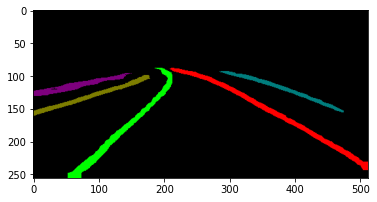

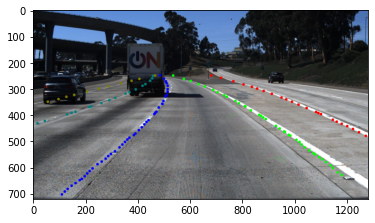

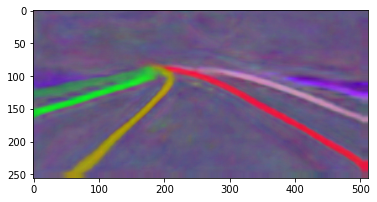

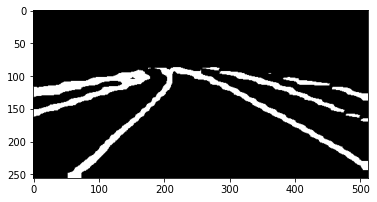

In [ ]:
def TfLiteInference(tflite_model_path, input_image_path):

    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output1_details = interpreter.get_output_details()[0] # Binary Image Output
    output2_details = interpreter.get_output_details()[1] # Instance Image Output

    image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    image_vis = image
    image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR)
    image = image / 127.5 - 1.0
    test = np.expand_dims(image, axis=0)
    test = test.astype('float32')

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        test = test / input_scale + input_zero_point
        test = test.astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test)
    interpreter.invoke()
    binary_seg_ret = interpreter.get_tensor(output1_details["index"])[0]
    instance_seg_ret = interpreter.get_tensor(output2_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output1_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        binary_seg_ret = binary_seg_ret.astype(np.float32)
        binary_seg_ret = (binary_seg_ret - output_zero_point) * output_scale
    output_scale, output_zero_point = output2_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        instance_seg_ret = instance_seg_ret.astype(np.float32)
        instance_seg_ret = (instance_seg_ret - output_zero_point) * output_scale

    postprocessor = lanenet_postprocess.LaneNetPostProcessor(cfg=CFG)
    postprocess_result = postprocessor.postprocess(
            binary_seg_result=binary_seg_ret,
            instance_seg_result=instance_seg_ret,
            source_image=image_vis
        )
    mask_image = postprocess_result['mask_image']

    for i in range(CFG.MODEL.EMBEDDING_FEATS_DIMS):
        instance_seg_ret[:, :, i] = minmax_scale(instance_seg_ret[:, :, i])
    embedding_image = np.array(instance_seg_ret, np.uint8)

    plt.figure('mask_image')
    plt.imshow(mask_image[:, :, (2, 1, 0)])
    plt.figure('src_image')
    plt.imshow(image_vis[:, :, (2, 1, 0)])
    plt.figure('instance_image')
    plt.imshow(embedding_image[:, :, (2, 1, 0)])
    plt.figure('binary_image')
    plt.imshow(binary_seg_ret * 255, cmap='gray')
    plt.show()

tflite_model_path = '/content/saved_model_quantized.tflite'
input_image_path = '/content/lanenet-lane-detection/data/tusimple_test_image/0.jpg'
TfLiteInference(tflite_model_path, input_image_path)

# 11/10 Compile with Edge TPU Compiler

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  16801      0 --:--:-- --:--:-- --:--:-- 16690
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/mach

In [ ]:
# !rm -rf /content/edgetpu_model_1110/
# !mkdir /content/edgetpu_model_1110/
# %cd /content/edgetpu_model_1110/
# % cd /content/

!edgetpu_compiler /content/temp/saved_model.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1357 ms.

Input model: /content/temp/saved_model.tflite
Input size: 2.38MiB
Output model: saved_model_edgetpu.tflite
Output size: 2.56MiB
On-chip memory used for caching model parameters: 2.40MiB
On-chip memory remaining for caching model parameters: 3.94MiB
Off-chip memory used for streaming uncached model parameters: 320.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 83
Operation log: saved_model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 82
Number of operations that will run on CPU: 1
See the operation log file for individual operation details

# Steps to run Inference on Coral Board

1. Log in to Coral Board. SCP the saved_model_quantized_edgetpu.tflite and run_inference.py files to the Coral Board.

Example:
scp -r \~/Downloads/saved_model_quantized_edgetpu.tflite mendel@<Board's IP address>:~/

2. Run the following:

git clone https://github.com/MaybeShewill-CV/lanenet-lane-detection.git

3. Check the possible locations of the pip.conf configuration file using: pip config -v list

4. Check if any of the files printed on the terminal exist on your system. If they exist, edit one of those files in the next step (no need to create it again). Otherwise create a new config file for yourself - this is what I had to do.

5. Creating a config file: (Inside any folder of your choice) 

touch pip.conf

export PIP_CONFIG_FILE=/path/to/pip.conf

6. Edit the pip config file using Vim or VSCode or whatever. Add the following two lines in that file:

[global]

extra-index-url=https://www.piwheels.org/simple

Now you can install any python libraries you want.

Reference for Step 6: https://www.piwheels.org/

7. Install required libraries

pip3 install opencv-python

pip3 install numpy

pip3 install matplotlib

pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime


8. Edit the paths on lines 133 and 134 of run_inference.py as required. Place run_inference.py inside the main folder of the lanenet repository that you cloned in Step 1.

9. Run the python file:

python3 run_inference.py

10. This program will save the output images as files in the same folder, and print execution time to the terminal.

# 11/18 Saving TF model as a .pb file: Pruned Model

The output of the following cell shows that the saved_model before pruning has 2 outputs. We wish to keep the binary_seg_image output and remove the instance_seg_image output from our graph.

In [ ]:
!saved_model_cli show --dir=/Users/praniljoshi/Desktop/pruning_WIP/a_unpruned_model/ --all

In [ ]:
def get_graph_def_from_saved_model(saved_model_dir): 
  with tf.Session() as session:
    meta_graph_def = tf.saved_model.loader.load(
    session,
    tags=[tf.saved_model.tag_constants.SERVING],
    export_dir=saved_model_dir
  ) 
  return meta_graph_def.graph_def

def describe_graph(graph_def, show_nodes=False):
  print('Input Feature Nodes: {}'.format(
      [node.name for node in graph_def.node if node.op=='Placeholder']))
  print('')
  print('Unused Nodes: {}'.format(
      [node.name for node in graph_def.node if 'unused'  in node.name]))
  print('')
  # print('Output Nodes: {}'.format( 
  #     [node.name for node in graph_def.node if (
  #         'predictions' in node.name or 'softmax' in node.name)]))
  # print('')
  print('Quantization Nodes: {}'.format(
      [node.name for node in graph_def.node if 'quant' in node.name]))
  print('')
  print('Constant Count: {}'.format(
      len([node for node in graph_def.node if node.op=='Const'])))
  print('')
  print('Variable Count: {}'.format(
      len([node for node in graph_def.node if 'Variable' in node.op])))
  print('')
  print('Identity Count: {}'.format(
      len([node for node in graph_def.node if node.op=='Identity'])))
  print('', 'Total nodes: {}'.format(len(graph_def.node)), '')

  if show_nodes==True:
    for node in graph_def.node:
      print('Op:{} - Name: {}'.format(node.op, node.name))

## Freeze the graph

Provide only the required output node corresponding to the binary_seg_image output to the output_node_names argument. This will freeze the graph after keeping only those nodes which are required to compute the binary_seg_image output.

In [ ]:

from tensorflow.python.tools import freeze_graph

def freeze_model(saved_model_dir, output_node_names, output_filename):
  output_graph_filename = os.path.join(saved_model_dir, output_filename)
  initializer_nodes = ''
  freeze_graph.freeze_graph(
      input_saved_model_dir=saved_model_dir,
      output_graph=output_graph_filename,
      saved_model_tags = tf.saved_model.tag_constants.SERVING, #tf.compat.v1.saved_model.tag_constants.SERVING,
      output_node_names=output_node_names,
      initializer_nodes=initializer_nodes,
      input_graph=None,
      input_saver=False,
      input_binary=False,
      input_checkpoint=None,
      restore_op_name=None,
      filename_tensor_name=None,
      clear_devices=False,
      input_meta_graph=False,
  )
  print('graph frozen!')

freeze_model('/Users/praniljoshi/Desktop/pruning_WIP/a_unpruned_model', 
'LaneNet/bisenetv2_backend/binary_seg/ArgMax', 
'/Users/praniljoshi/Desktop/pruning_WIP/b_frozen_graph/saved_model.pb')

## Optimize the graph

The following cell runs some more optimization steps on the graph. While the freeze_graph function should removee unused nodes by itself, we still run the 'strip_unused_nodes' transformation on the same graph again for good measure.

The input argument to the following function is the output '.pb' file produced by the previous 'freeze_model' function

In [ ]:
from tensorflow.tools.graph_transforms import TransformGraph

def get_graph_def_from_file(graph_filepath):
  with tf.Graph().as_default():
    with tf.gfile.GFile(graph_filepath, 'rb') as f:
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
      return graph_def

def optimize_graph(model_dir, graph_filename, transforms, output_node, output_dir):
  input_names = []
  output_names = [output_node]
  if graph_filename is None:
    graph_def = get_graph_def_from_saved_model(model_dir)
  else:
    graph_def = get_graph_def_from_file(os.path.join(model_dir, graph_filename))
  optimized_graph_def = TransformGraph(
      graph_def,
      input_names,
      output_names,
      transforms)
  tf.train.write_graph(optimized_graph_def,
                      logdir=output_dir,
                      as_text=False,
                      name='saved_model.pb')
  print('Graph optimized!')

transforms = [
 'remove_nodes(op=Identity)', 
 'merge_duplicate_nodes',
 'strip_unused_nodes',
 'fold_constants(ignore_errors=true)',
 'fold_batch_norms'
]
optimize_graph('/Users/praniljoshi/Desktop/pruning_WIP/b_frozen_graph', 
  'saved_model.pb' , 
  transforms, 
  'LaneNet/bisenetv2_backend/binary_seg/ArgMax:0',
  output_dir='/Users/praniljoshi/Desktop/pruning_WIP/c_frozen_optimized_graph')

## Convert Optimized GraphDef back to SavedModel format

In [ ]:
def convert_graph_def_to_saved_model(export_dir, graph_filepath):
  if tf.gfile.Exists(export_dir):
    tf.gfile.DeleteRecursively(export_dir)
  graph_def = get_graph_def_from_file(graph_filepath)
  with tf.Session(graph=tf.Graph()) as session:
    tf.import_graph_def(graph_def, name='')
    tf.saved_model.simple_save(
        session,
        export_dir,
        inputs={
            node.name: session.graph.get_tensor_by_name(
                '{}:0'.format(node.name))
            for node in graph_def.node if node.op=='Placeholder'},
        outputs={'binary_seg_image': session.graph.get_tensor_by_name(
            'LaneNet/bisenetv2_backend/binary_seg/ArgMax:0')}
    )
    print('Optimized graph converted to SavedModel!')


optimized_filepath = '/Users/praniljoshi/Desktop/pruning_WIP/c_frozen_optimized_graph/saved_model.pb'
optimized_export_dir = '/Users/praniljoshi/Desktop/pruning_WIP/d_frozen_optimized_model'
convert_graph_def_to_saved_model(optimized_export_dir, optimized_filepath)

In [ ]:
!saved_model_cli show --dir=/Users/praniljoshi/Desktop/pruning_WIP/d_frozen_optimized_model/ --all

## Run inference on optimized savedmodel

We run inference as usual on the newly obtained pruned+frozen+optimized savedmodel and verify that it works correctly and produces the required binary_seg_image output

In [ ]:
import os.path as ops
import tensorflow as tf
import time

from lanenet_model import lanenet
from local_utils.log_util import init_logger

LOG = init_logger.get_logger(log_file_name_prefix='lanenet_test')

def test_lanenet(image_path, weights_path, mode="ckptinference", export_path = None):
    """
    :param image_path:
    :param mode:
      "ckptinference": Run inference on ckpt model obtained from GitHub
      "ckpttopb": Save new .pb model to export_path
      "pbinference": Run inference on pb model located in weights_path directory
    :param weights_path:
    :export_path
    :return:
    """
    image, image_vis = getPreprocessedImage(image_path)

    tf.reset_default_graph()

    if(mode != "pbinference"):
        input_tensor = tf.placeholder(dtype=tf.float32, shape=[1, 256, 512, 3], name='input_tensor')
        net = lanenet.LaneNet(phase='test', cfg=CFG)
        # binary_seg_ret, instance_seg_ret = net.inference(input_tensor=input_tensor, name='LaneNet')
        binary_seg_ret = net.inference(input_tensor=input_tensor, name='LaneNet')

    postprocessor = lanenet_postprocess.LaneNetPostProcessor(cfg=CFG)
    # Set sess configuration
    sess_config = tf.ConfigProto()
    sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.GPU.GPU_MEMORY_FRACTION
    sess_config.gpu_options.allow_growth = CFG.GPU.TF_ALLOW_GROWTH
    sess_config.gpu_options.allocator_type = 'BFC'

    sess = tf.Session(config=sess_config)

    if(mode != "pbinference"):
        # define moving average version of the learned variables for eval
        with tf.variable_scope(name_or_scope='moving_avg'):
            variable_averages = tf.train.ExponentialMovingAverage(
                CFG.SOLVER.MOVING_AVE_DECAY)
            variables_to_restore = variable_averages.variables_to_restore()

        # define saver
        saver = tf.train.Saver(variables_to_restore)

    with sess.as_default():
        if(mode != "pbinference"):
            t_start_sess = time.time()
            # saver = tf.train.import_meta_graph(weights_path+ '.meta')
            saver.restore(sess=sess, save_path=weights_path)
            LOG.info('Weights loaded, cost time: {:.5f}s'.format(time.time() - t_start_sess))
            saver.save(sess, 'MODEL_TF')

            t_start = time.time()
            loop_times = 1 # 500
            for i in range(loop_times):
                # binary_seg_image, instance_seg_ret = sess.run(
                binary_seg_image = sess.run(
                    binary_seg_ret,
                    feed_dict={input_tensor: [image]}
                )
            t_cost = time.time() - t_start
            t_cost /= loop_times
            LOG.info('Single imgae inference cost time: {:.5f}s'.format(t_cost))

        if(mode == "ckpttopb"):
            from tensorflow.python.framework import graph_util
            # constant_graph = graph_util.convert_variables_to_constants(
            # sess, sess.graph.as_graph_def(), ['output']
            # )
            # frozen = graph_util.remove_training_nodes(sess.graph.as_graph_def())

            tf.saved_model.simple_save(session=sess, export_dir=export_path,
                                    inputs={'image': input_tensor},
                                    outputs={
                                        'binary_seg_image': binary_seg_ret
                                    })
                  # # Untested alternative: Save with SavedModelBuilder
                  # builder = tf.saved_model.Builder('/content/temp/')
                  # sig_def = tf.saved_model.predict_signature_def(
                  #     inputs={'image': input_tensor},
                  #     outputs={'binary_seg_image': binary_seg_ret, 'instance_seg_image': instance_seg_ret})
                  # builder.add_meta_graph_and_variables(
                  #     sess, tags=["serve"], signature_def_map={
                  #         tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY: sig_def
                  # })
                  # builder.save()

        else:
            if(mode=="pbinference"):
                meta_graph = tf.saved_model.load(sess=sess, tags=["serve"], export_dir=weights_path)
                sig_def = meta_graph.signature_def[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

                describe_graph(meta_graph.graph_def)
                for node in meta_graph.graph_def.node:
                    print(node.name+"\n")
                
                

                # input_name = sig_def.inputs['image'].name
                input_name = sig_def.inputs['input_tensor'].name

                
                output_name1 = sig_def.outputs['binary_seg_image'].name
                # o1 = tf.get_default_graph().get_tensor_by_name(output_name1)
                # output_name2 = sig_def.outputs['instance_seg_image'].name
                # o2 = tf.get_default_graph().get_tensor_by_name(output_name2)

                t_start = time.time()
                loop_times = 1 # 500
                for i in range(loop_times):
                    # binary_seg_image, instance_seg_image = sess.run(
                    binary_seg_image = sess.run(
                        output_name1,
                        feed_dict={input_name: [image]}
                    )
                t_cost = time.time() - t_start
                t_cost /= loop_times
                LOG.info('Single imgae inference cost time: {:.5f}s'.format(t_cost))

            # postprocess_result = postprocessor.postprocess(
            #     binary_seg_result=binary_seg_image[0],
            #     instance_seg_result=instance_seg_image[0],
            #     source_image=image_vis
            # )
            # mask_image = postprocess_result['mask_image']

            # for i in range(CFG.MODEL.EMBEDDING_FEATS_DIMS):
            #     instance_seg_image[0][:, :, i] = minmax_scale(instance_seg_image[0][:, :, i])
            # embedding_image = np.array(instance_seg_image[0], np.uint8)

            # plt.figure('mask_image')
            # plt.imshow(mask_image[:, :, (2, 1, 0)])
            # plt.figure('src_image')
            # plt.imshow(image_vis[:, :, (2, 1, 0)])
            # plt.figure('instance_image')
            # plt.imshow(embedding_image[:, :, (2, 1, 0)])
            plt.figure('binary_image')
            plt.imshow(binary_seg_image[0] * 255, cmap='gray')
            plt.show()

    sess.close()

    return

image_path = './data/tusimple_test_image/0.jpg'
weights_path = '/Users/praniljoshi/Desktop/pruning_WIP/d_frozen_optimized_model'
test_lanenet(image_path, weights_path, mode="pbinference")

## Convert .pb to .tflite

In [ ]:
import os
def PbToTflite(weights_path, export_path, quantize=True, repdatazip_path=''):
    # repdatazip_path: Path to zip file for representative data. Only used if quantize==True

    converter = tf.lite.TFLiteConverter.from_saved_model(weights_path)

    if(quantize):
        import zipfile
        repdata_path = './'
        with zipfile.ZipFile(repdatazip_path, 'r') as zip_ref:
            zip_ref.extractall(repdata_path)
            
        repdata = []
        for subdir, dirs, files in os.walk('/Users/praniljoshi/Desktop/pruning_WIP/repdata'):
            for file in files:
                # print(file)
                filepath = os.path.join(subdir, file)
                image, image_vis = getPreprocessedImage(filepath)
                test = np.expand_dims(image, axis=0)
                test = test.astype('float32')
                repdata.append(test)

        def representative_dataset():
            print("in repdata", len(repdata))
            for i in range(len(repdata)):
                print(i)
                if(i>100):
                    break
                yield([repdata[i]])

        # Set the optimization flag.
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # Enforce integer only quantization
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
        converter.quantized_input_stats = {'input_tensor' : (-1., 1.)}
        # Provide a representative dataset to ensure we quantize correctly.
        converter.representative_dataset = representative_dataset

    model = converter.convert()

    # Save the model to disk
    os.mkdir(export_path)
    open(export_path+'/saved_model.tflite', "wb").write(model)

# Unquantized TFLite
# weights_path = '/content/pbmodel1026'
# export_path = '/content/tflitemodel1026'
# PbToTflite(weights_path, export_path, quantize=False)

# Quantized TFLite
# weights_path = './pbmodel1026'
%cd /Users/praniljoshi/Desktop/pruning_WIP/
weights_path = '/Users/praniljoshi/Desktop/pruning_WIP/d_frozen_optimized_model'
export_path = './tflitemodelquantized1101'
repdatazip_path = '/Users/praniljoshi/Desktop/pruning_WIP/repdata.zip'
PbToTflite(weights_path, export_path, repdatazip_path=repdatazip_path)


## Compile with Edge TPU Compiler

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

In [ ]:
# !rm -rf /content/edgetpu_model_1110/
# !mkdir /content/edgetpu_model_1110/
# %cd /content/edgetpu_model_1110/
# % cd /content/

!edgetpu_compiler /content/temp/saved_model.tflite